# The AI Revolution: Predictable or Unexpected?

## Situation
AI has rapidly transitioned from a niche research area to a mainstream technology, with a surge in AI-powered products and services.

## Complication
This AI revolution has reshaped the technological landscape and significantly influenced the direction and priorities of companies across various industries.

## Question
Could the current AI boom have been predicted by analysing academic research trends and public interest?

## Aim
Examine AI-related academic paper datasets and Google Trends data to identify:
- Key milestones
- Shifts in focus
- Public sentiment

These factors may have foreshadowed the current AI revolution and its impact on the field and society.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import seaborn as sns
import json
from nltk.corpus import stopwords
from wordcloud import WordCloud
import time
from nltk import ngrams
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")

## Gathering the Complete Dataset for Academic Analysis

To gather the complete dataset needed for the academic portion of the analysis it took a three step process.

### Step 1: Utilising the arXiv Complete Metadata Dataset

The first step involved using the arXiv complete metadata dataset from Kaggle.com. This dataset is a large file, approximately 4GB in size, containing around 2.5 million rows of data. It includes the following columns

- `id`: The ArXiv ID of the paper, which can be used to access the paper.
- `submitter`: The person who submitted the paper.
- `authors`: The authors of the paper.
- `title`: The title of the paper.
- `comments`: Additional information about the paper, such as the number of pages and figures.
- `journal-ref`: Information about the journal in which the paper was published.
- `doi`: The Digital Object Identifier (DOI) of the paper.
- `abstract`: The abstract of the paper.
- `categories`: The categories or tags assigned to the paper in the ArXiv system.
- `versions`: The version history of the paper.

This dataset serves as a comprehensive source of information for analysing academic papers related to the topic of interest.

Source: [arXiv Dataset](https://www.kaggle.com/datasets/Cornell-University/arxiv/data)

### Reading the JSON File

Due to the large size of the JSON file (approximately 4GB), I employed two different methods to read the file:

1. **Full Data Reading**: In this method, I read the entire JSON file line by line and loaded each line as a JSON object into a list called `arxivlist`. This approach allows me to access and work with the complete dataset, enabling me to perform comprehensive analysis and create detailed graphs.

2. **Partial Data Reading (for testing)**: Considering the substantial size of the JSON file, reading the entire dataset every time during the development and testing phase can be time-consuming. To expedite the testing process, I implemented a method that reads only a subset of the data. Specifically, you read every 20th line of the JSON file. This partial reading approach helps quickly test and validate your code without the need to process the entire dataset each time.

Due to the dataset's formatting I used python json functions over pandas faster alternatives.

A separate sample json is used when demoing this notebook.

In [2]:
arxivlist = []
full = False
sample = True
if sample:
    df = pd.read_json('arxiv_sample.json')
    
else:
    with open('arxiv-metadata-oai-snapshot.json', 'r') as file:
        if full:
            for line in file:
                arxivlist.append(json.loads(line))
        else: 
            for i, line in enumerate(file):
                if i % 20 == 0:
                # Load the JSON data from every 20th line for testing
                    arxivlist.append(json.loads(line))
    df = pd.DataFrame.from_records(arxivlist)


#### **Extracting the Creation Date and Cleaning the DataFrame**

1. **Extracting the Creation Date**: Since I am primarily interested in the date when a paper was created, I extracted this information from the `versions` column and moved it to the already presented 'update_date' column. 

2. **Dropping Unnecessary Columns**: To streamline your DataFrame and reduce memory usage, I identified and dropped columns that were not relevant to the analysis. 

3. **Removing Duplicates**: To ensure data integrity and avoid any potential biases caused by duplicate entries, I removed duplicate rows from my DataFrame. 

In [3]:
df['first_version_created'] = df['versions'].apply(lambda x: x[0]['created'])
df['update_date'] = df['first_version_created']
droppingcolumsn = ['versions', 'license', 'report-no','comments','journal-ref','doi',]
df.drop(droppingcolumsn, axis=1, inplace=True)
print(df.info())
print(df.isnull().sum())
print(df.columns)
df['update_date'] = pd.to_datetime(df['update_date'])
df.drop_duplicates(['abstract',], inplace=True)


<class 'pandas.core.frame.DataFrame'>
Index: 122762 entries, 0 to 122761
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   id                     122762 non-null  object
 1   submitter              122013 non-null  object
 2   authors                122762 non-null  object
 3   title                  122762 non-null  object
 4   categories             122762 non-null  object
 5   abstract               122762 non-null  object
 6   update_date            122762 non-null  object
 7   authors_parsed         122762 non-null  object
 8   first_version_created  122762 non-null  object
dtypes: object(9)
memory usage: 9.4+ MB
None
id                         0
submitter                749
authors                    0
title                      0
categories                 0
abstract                   0
update_date                0
authors_parsed             0
first_version_created      0
dtype: int64
Inde

#### **Mapping and Splitting Categories**

I  focused on the `categories` column, which contained information about the subject categories assigned to each paper. To enhance the interpretability and usability of this column, I performed two key transformations:

1. **Mapping Categories**: The original `categories` column contained abbreviated codes representing different subject categories. To make these categories more understandable and meaningful, I utilised a taxonomy provided by arXiv (available at https://arxiv.org/category_taxonomy). 

2. **Splitting Categories**: After mapping the categories to their full names, I noticed that some papers were associated with multiple categories. To handle this, I decided to split the categories and create separate rows for each category.

Splitting the categories into separate rows also facilitated the process of masking or filtering the DataFrame later on. By having each category in its own row, I could easily select papers belonging to specific categories of interest.

In [4]:
category_map = {
    'cs.AI': 'Artificial Intelligence', 'cs.AR': 'Hardware Architecture',    'cs.CC': 'Computational Complexity', 'cs.CE': 'Computational Engineering, Finance, and Science',
    'cs.CG': 'Computational Geometry', 'cs.CL': 'Computation and Language',    'cs.CR': 'Cryptography and Security', 'cs.CV': 'Computer Vision and Pattern Recognition',
    'cs.CY': 'Computers and Society', 'cs.DB': 'Databases',    'cs.DC': 'Distributed, Parallel, and Cluster Computing', 'cs.DL': 'Digital Libraries',
    'cs.DM': 'Discrete Mathematics', 'cs.DS': 'Data Structures and Algorithms',    'cs.ET': 'Emerging Technologies', 'cs.FL': 'Formal Languages and Automata Theory',
    'cs.GL': 'General Literature', 'cs.GR': 'Graphics',    'cs.GT': 'Computer Science and Game Theory', 'cs.HC': 'Human-Computer Interaction',
    'cs.IR': 'Information Retrieval', 'cs.IT': 'Information Theory',    'cs.LG': 'Machine Learning', 'cs.LO': 'Logic in Computer Science',
    'cs.MA': 'Multiagent Systems', 'cs.MM': 'Multimedia',    'cs.MS': 'Mathematical Software', 'cs.NA': 'Numerical Analysis',
    'cs.NE': 'Neural and Evolutionary Computing', 'cs.NI': 'Networking and Internet Architecture',    'cs.OH': 'Other Computer Science', 'cs.OS': 'Operating Systems',
    'cs.PF': 'Performance', 'cs.PL': 'Programming Languages',    'cs.RO': 'Robotics', 'cs.SC': 'Symbolic Computation',
    'cs.SD': 'Sound', 'cs.SE': 'Software Engineering',    'cs.SI': 'Social and Information Networks', 'cs.SY': 'Systems and Control',
    'econ.EM': 'Econometrics', 'econ.GN': 'General Economics',    'econ.TH': 'Theoretical Economics', 'eess.AS': 'Audio and Speech Processing',
    'eess.IV': 'Image and Video Processing', 'eess.SP': 'Signal Processing',    'eess.SY': 'Systems and Control', 'math.AC': 'Commutative Algebra',
    'math.AG': 'Algebraic Geometry', 'math.AP': 'Analysis of PDEs',    'math.AT': 'Algebraic Topology', 'math.CA': 'Classical Analysis and ODEs',
    'math.CO': 'Combinatorics', 'math.CT': 'Category Theory',    'math.CV': 'Complex Variables', 'math.DG': 'Differential Geometry',
    'math.DS': 'Dynamical Systems', 'math.FA': 'Functional Analysis',    'math.GM': 'General Mathematics', 'math.GN': 'General Topology',
    'math.GR': 'Group Theory', 'math.GT': 'Geometric Topology',    'math.HO': 'History and Overview', 'math.IT': 'Information Theory',
    'math.KT': 'K-Theory and Homology', 'math.LO': 'Logic',    'math.MG': 'Metric Geometry', 'math.MP': 'Mathematical Physics',
    'math.NA': 'Numerical Analysis', 'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',    'astro-ph.EP': 'Earth and Planetary Astrophysics', 'astro-ph.GA': 'Astrophysics of Galaxies',
    'astro-ph.HE': 'High Energy Astrophysical Phenomena', 'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',    'astro-ph.SR': 'Solar and Stellar Astrophysics', 'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
    'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics', 'cond-mat.mtrl-sci': 'Materials Science',    'cond-mat.other': 'Other Condensed Matter', 'cond-mat.quant-gas': 'Quantum Gases',
    'cond-mat.soft': 'Soft Condensed Matter', 'cond-mat.stat-mech': 'Statistical Mechanics',    'cond-mat.str-el': 'Strongly Correlated Electrons', 'cond-mat.supr-con': 'Superconductivity',
    'gr-qc': 'General Relativity and Quantum Cosmology', 'hep-ex': 'High Energy Physics - Experiment',    'hep-lat': 'High Energy Physics - Lattice', 'hep-ph': 'High Energy Physics - Phenomenology',
    'hep-th': 'High Energy Physics - Theory', 'math-ph': 'Mathematical Physics',    'nlin.AO': 'Adaptation and Self-Organizing Systems', 'nlin.CD': 'Chaotic Dynamics',
    'nlin.CG': 'Cellular Automata and Lattice Gases', 'nlin.PS': 'Pattern Formation and Solitons',    'nlin.SI': 'Exactly Solvable and Integrable Systems', 'nucl-ex': 'Nuclear Experiment',
    'nucl-th': 'Nuclear Theory', 'physics.acc-ph': 'Accelerator Physics',    'physics.ao-ph': 'Atmospheric and Oceanic Physics', 'physics.app-ph': 'Applied Physics',
    'physics.atm-clus': 'Atomic and Molecular Clusters', 'physics.atom-ph': 'Atomic Physics',    'physics.bio-ph': 'Biological Physics', 'physics.chem-ph': 'Chemical Physics',
    'physics.class-ph': 'Classical Physics', 'physics.comp-ph': 'Computational Physics',    'physics.data-an': 'Data Analysis, Statistics and Probability', 'physics.ed-ph': 'Physics Education',
    'physics.flu-dyn': 'Fluid Dynamics', 'physics.gen-ph': 'General Physics',    'physics.geo-ph': 'Geophysics', 'physics.hist-ph': 'History and Philosophy of Physics',
    'physics.ins-det': 'Instrumentation and Detectors', 'physics.med-ph': 'Medical Physics',    'physics.optics': 'Optics', 'physics.plasm-ph': 'Plasma Physics',
    'physics.pop-ph': 'Popular Physics', 'physics.soc-ph': 'Physics and Society',    'physics.space-ph': 'Space Physics', 'quant-ph': 'Quantum Physics',
    'q-bio.BM': 'Biomolec', 'q-fin.CP': 'Computational Finance',    'q-fin.EC': 'Economics', 'q-fin.GN': 'General Finance',
    'q-fin.MF': 'Mathematical Finance', 'q-fin.PM': 'Portfolio Management',    'q-fin.PR': 'Pricing of Securities', 'q-fin.RM': 'Risk Management',
    'q-fin.ST': 'Statistical Finance', 'q-fin.TR': 'Trading and Market Microstructure',    'stat.AP': 'Applications', 'stat.CO': 'Computation',
    'stat.ME': 'Methodology', 'stat.ML': 'Machine Learning',    'stat.OT': 'Other Statistics', 'stat.TH': 'Statistics Theory',
    'astro-PH': 'Astrophysics', 'cond-mat': 'Condensed Matter',    'nlin': 'Nonlinear-Sciences',
}

In [5]:
def category_splitting(categories):
    """
    Splits cells into separate categories based on spaces, gets new category values from the dictionary
    (with default value), and returns a list of categories.
    """
    catv2 = [category_map.get(catvalue, catvalue) for catvalue in categories.split()]
    return catv2

df['categories'] = df['categories'].apply(category_splitting)
df = df.explode('categories')
# Define the AI categories
ai_categories = ['Artificial Intelligence', 'Computer Vision and Pattern Recognition', 'Machine Learning',
                 'Neural and Evolutionary Computing', 'Computation and Language']
# Filter the DataFrame based on the presence of AI categories in the 'categories' column
ai_mask_df = df[df['categories'].isin(ai_categories)]


### **Step 2: Retrieving Citation Counts and Author Affiliations using the Semantic Scholar API**

In the second step of gathering my data, I utilised the Semantic Scholar API (api.semanticscholar.org) to access additional information about the papers in my dataset. By leveraging the paper IDs obtained from the arXiv dataset using them as parameters, I was able to retrieve two key data points for each paper:

1. **Citation Count**: I used the Semantic Scholar API to fetch the citation count for each paper in my dataset. The citation count represents the number of times a paper has been cited by other publications. This information provides valuable insights into the impact and popularity of a paper within the scientific community.
   
2. **Author Affiliations**: In addition to the citation counts, I also utilised the Semantic Scholar API to gather information about the affiliations of the authors associated with each paper. Author affiliations refer to the institutions or organisations with which the authors are affiliated.

This additional data enables me to explore various aspects of the papers, such as their popularity, impact, and the affiliations of the researchers involved.

In [6]:
def AI_id_retriever():
    ai_mask_df[['id']].to_csv('ai_ids.csv', index=False)

#### **Sending Requests to the Semantic Scholar API**

I used the list of AI-related paper IDs (obtained from the `ai_mask_df`) as the source for sending requests to the Semantic Scholar API. I referred to the API documentation (https://api.semanticscholar.org/api-docs/graph#tag/Paper-Data/operation/post_graph_get_papers) and implemented the code in a separate file.

To ensure compatibility with the API, I made the following adjustments:

1. I added the "ARXIV:" prefix to the paper IDs in the API requests, as specified in the documentation, since I was using arXiv paper IDs.

2. I sent the maximum number of requests allowed by the API at a time, which was 500 requests per batch.

3. I made minor formatting changes to the CSV file generated from the API responses to handle poorly formatted author affiliations.

4. I included print statements throughout the code to monitor the progress and ensure the program hadn't crashed, as the execution time was considerable.

By making these adjustments and following the API documentation, I successfully retrieved the citation counts and author affiliations for the AI-related papers using the Semantic Scholar API.

In [7]:
def SemanticScholarAPIRequester():
    import requests
    import csv
    import time
    
    api_url = 'https://api.semanticscholar.org/graph/v1/paper/batch'
    params = {
        'fields': 'paperId,citationCount,authors.name,authors.affiliations'
    }
    max_retries = 5 # Defines the maximum number of retries and the initial backoff time
    backoff_time = 1
    
    paper_ids = []
    with open('ai_ids.csv', 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            paper_id = row['id']
            paper_ids.append(paper_id)
    
    batch_size = 500
    batches = [paper_ids[i:i+batch_size] for i in range(0, len(paper_ids), batch_size)]
    
    with open('citation_counts.csv', 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['id', 'citation count', 'author names', 'author affiliations'])
    
        for batch in batches:
            print(f"Fetching citation counts for batch: {batch}")
            # Add the "ARXIV:" prefix to the paper IDs for the API request
            batch_with_prefix = [f"ARXIV:{paper_id}" for paper_id in batch]
            retries = 0
            while retries < max_retries:
                try:
                    response = requests.post(api_url, params=params, json={"ids": batch_with_prefix})
                    response.raise_for_status()  # Raise an exception for 4xx or 5xx status codes
                    data = response.json()
                    
                    for paper, original_id in zip(data, batch):
                        if paper is not None and 'paperId' in paper and 'citationCount' in paper and 'authors' in paper:
                            citation_count = paper['citationCount']
                            author_names = [author['name'] for author in paper['authors'] if 'name' in author]
                            author_affiliations = [', '.join(author.get('affiliations', [])) for author in paper.get('authors', [])]
                            writer.writerow([original_id, citation_count, ''.join(author_names), ''.join(author_affiliations)])
                        else:
                            print(f"Skipping paper due to missing data: {original_id}")
                    
                    break  # Break out of the retry loop if the request is successful
                except requests.exceptions.RequestException as e:
                    if e.response is not None and e.response.status_code == 429:
                        print(f"Rate limit exceeded. Retrying in {backoff_time} seconds...")
                        time.sleep(backoff_time)
                        backoff_time *= 2  
                        retries += 1
                    else:
                        print(f"Error occurred while fetching data for batch: {batch}")
                        print(f"Error details: {str(e)}")
                        break  # Break out of the retry loop for other types of errors
            
    print("Citation counts stored in citation_counts.csv")


### **Step 3: Retrieving Country Information using the Universities Library**

In the third step, I utilised the Universities Python library (https://pypi.org/project/universities/) to obtain the countries associated with the universities retrieved from the author affiliations in the previous API requests. Due to the time-consuming nature of this process, I implemented the code in a separate file and read from and wrote to CSV files.

I made the following adjustments to optimise the code:

1. I used the `ast` library to convert the string representation of the list of author affiliations to an actual list.

2. I initialised the `universities.API()` and used the `.lucky()` method as per the library's documentation to search for the universities.

3. I employed the `concurrent.futures` library to parallelize the requests, sending 10 requests at a time to speed up the process.

By leveraging the Universities library and making these adjustments, I efficiently retrieved the country information associated with the universities mentioned in the author affiliations, enhancing the dataset with geographical context.

In [8]:
def UniversityLocationFinder():
    import pandas as pd
    import universities
    import ast
    from concurrent.futures import ThreadPoolExecutor, as_completed
    
    uni = universities.API()
    
    df = pd.read_csv('cleaned_citation_counts.csv')
    
    countries_list = [None] * len(df)
    
    def get_countries(affiliation_str, index):
        affiliation_list = ast.literal_eval(affiliation_str)
        countries = []
        for affiliation in affiliation_list:
            # Use uni.lucky to search for each affiliation
            result = uni.lucky(name=affiliation)
            # Check if a valid University object is returned
            if isinstance(result, universities.models.University):
                countries.append(result.country)
        countries_str = ', '.join(countries)
        countries_list[index] = countries_str
    
    with ThreadPoolExecutor(max_workers=10) as executor:  
        futures = [executor.submit(get_countries, affiliation_str, index)
                   for index, affiliation_str in enumerate(df['author affiliations'])]
        for future in as_completed(futures):
            pass
    
    df['Country'] = countries_list
    df.to_csv('cleaned_citation_counts2.csv', index=False)
    print("CSV file updated with the 'Country' column.")

I added created two additional columns to count the number of authors on each paper and to count the number of authors_parsed.

#### #currently this is unused in my analysis.

In [9]:
def count_authors(authors_string):
    return authors_string.count(',') + 1

def count_parsed_authors(authors_parsed):
    return len(authors_parsed)

df['num_authors'] = df['authors'].apply(count_authors)
df['num_authors_parsed'] = df['authors_parsed'].apply(count_parsed_authors)

# **ACADEMIC Dataset Analysis**
### **Text Preprocessing for Abstracts and Titles**

The abstract and title columns in my dataset contained a large amount of text data. To effectively utilise this information for visualisation, I performed text preprocessing on these columns. I executed the preprocessing steps in a separate file to store the results permanently, allowing me to easily access the processed text in my main file whenever needed.

During the text preprocessing, I applied the following transformations:

1. Removed **digits** from the text.
2. Removed **non-alphanumeric** characters.
3. Converted all text to **lowercase**.
4. Removed any word containing the **'$'** symbol, as it always indicated the presence of formulas or LaTeX symbols in my data.
5. Replaced newline characters with spaces to ensure proper formatting of the abstracts.
6. Eliminated **stop words**, which are commonly occurring words that carry little meaningful information. In order to emphasise the more significant and informative words in the text.


By preprocessing the text data in the abstract and title columns, I transformed it into a more usable format, enabling effective visualisation and analysis of the content.

I optimised the text preprocessing step by utilising the Natural Language Toolkit (`NLTK`) package. I found that using regular Python list comprehension for text preprocessing consumed too much RAM and was time-consuming. NLTK, a library for symbolic and statistical natural language processing (NLP) in English, provided a more efficient solution.

In [10]:
def TextProcessingPY():
    import json
    import csv
    import re
    import nltk
    from nltk.corpus import stopwords
    
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    
    def textpreprocessing(text):
        text = re.sub(r'\n', ' ', text) # Replace newline characters with spaces
        text = re.sub(r'\d+', '', text) # Remove digits
        text = re.sub(r'[^\w\s]', '', text) # Remove non-alphanumeric characters
        text = text.lower() # Convert to lowercase
        words = text.split()
        words = [word for word in words if word not in stop_words and '$' not in word] # Remove stop words and latex
        
        return ' '.join(words)
    
    # opens the JSON file and the outputs CSV file - Works line by line to read dataset and write processed text
    with open('arxiv-metadata-oai-snapshot.json', 'r') as json_file, open('abstractprocessed.csv', 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['id', 'title', 'abstract'])
        
        for line in json_file:
            data = json.loads(line)     
            # Extract the id, abstract, and title
            id = data.get('id', '')
            abstract = data.get('abstract', '')
            title = data.get('title', '')
    
            abstract_processed = textpreprocessing(abstract)
            title_processed = textpreprocessing(title)
            csv_writer.writerow([id, title_processed, abstract_processed])


## Importing and Merging Data

I imported the data gathered from the API scripts and added it to my main dataframe. I saved the original titles for later use in annotating graphs.

To merge the two dataframes from CSV files, I ensured that the data types for the index columns matched. After merging, I dropped the unnecessary columns to clean up the dataframe.

**A separate sample csv is used when demoing this notebook.**

In [11]:
ai_mask_df['old_title'] = ai_mask_df['title'].copy().astype(str)

if sample:
    abstractprocessed_df = pd.read_json('abstractprocessed_sample.csv') #read_json fit the structure of this csv better
else:
    #used usecols to save memory
    abstractprocessed_df = pd.read_csv('abstractprocessed.csv', encoding='latin1',dtype={0: str}, usecols=['id', 'title', 'abstract'])
abstractprocessed_df = abstractprocessed_df.reset_index(drop=True) 

ai_mask_df.loc[:, 'id'] = ai_mask_df['id'].astype(str)
abstractprocessed_df['id'] = abstractprocessed_df['id'].astype(str)

ai_mask_df = ai_mask_df.merge(abstractprocessed_df, on='id', how='left', suffixes=('', '_y'))

# Update the 'title' and 'abstract' columns in ai_mask_df with the values from abstractprocessed_df
ai_mask_df['title'] = ai_mask_df['title_y']
ai_mask_df['abstract'] =ai_mask_df['abstract_y']
ai_mask_df = ai_mask_df.drop(['title_y', 'abstract_y'], axis=1)

if sample:
    citation_counts_df = pd.read_csv('cleaned_citation_counts_sample.csv')
else:
    citation_counts_df = pd.read_csv('citation_counts.csv')

citation_counts_df['id'] = citation_counts_df['id'].astype(str)
ai_mask_df = pd.merge(ai_mask_df, citation_counts_df, on='id', how='left')

print(ai_mask_df.columns)

Index(['id', 'submitter', 'authors', 'title', 'categories', 'abstract',
       'update_date', 'authors_parsed', 'first_version_created', 'old_title',
       'citation count', 'author names', 'author affiliations', 'Country'],
      dtype='object')


## Optimising Memory Usage 

Due to the large dataset and high quantity of text data, I took several steps to ensure my code was as memory/RAM efficient as possible. This allowed my Python program to run without encountering memory errors.

I did a few key things to achieve this:

1. I used `del df` and `gc.collect()` functions to delete my full JSON dataframe when I was done using it. By calling the garbage collector, I ensured Python freed up the unused memory.

2. I was careful to only read in the necessary parts of the CSV using the `usecols=` parameter. This avoided loading unnecessary data into memory.

3. Instead of using Python's vanilla list comprehension, I opted for the `collections` package and its `Counter` functions. `Counter` doesn't use additional memory to store results; it live updates the list it's working on with the results.

By implementing these techniques, I successfully optimised my code's memory usage, allowing me to work with the large dataset efficiently.


## Analysing Common Terms and Phrase Changes in AI Category Papers

I'm now focusing on AI category papers to identify common terms and explore how phrase usage has evolved over time.

To optimise memory usage:
Instead of using Python's vanilla list comprehension, I opted for the collections package and its Counter functions. Counter doesn't use additional memory to store results; it live updates the list it's working on with the results.

### Data Processing

To begin, I processed my data efficiently using pandas functions:

1. I filtered and cleaned the data to select two time periods from the beginning and end of my dataset.
2. I created a processing function that combined the title and abstract columns into a single string and tokenise it.
3. I split the string into two sections:
   - Every individual word
   - Every 2-word combination (bigrams)
4. To generate the bigrams, I used the `ngrams()` function from the nltk library, which is memory-efficient compared to a pure Python approach.
5. I used `counter()` for all my word counting as I don't have enough memory to use regular methods when working on the full dataset.
6. While counting I removed any words matching my custom stopwords list (e.g., "used").
7. I then use a basic dictionary word mapping for high frequency terms to make sure they are combined into 1 tally.
8. Finally, I counted the frequency of the tokens and returned it as a dictionary along with the total word count.

I opted not to avoid stemming and lemmatization as I found this distorted the meaning of several key phrases in my AI data like 'machine learning'

In [12]:
#freeing up memory
import gc

#del df
#gc.collect()

df_2007_2010 = ai_mask_df[(ai_mask_df['update_date'] >= '2007-01-01') & (ai_mask_df['update_date'] <= '2012-12-31')]
df_2020_2023 = ai_mask_df[(ai_mask_df['update_date'] >= '2020-01-01') & (ai_mask_df['update_date'] <= '2023-12-31')]

df_2007_2010 = df_2007_2010.dropna(subset=['title', 'abstract'])
df_2020_2023 = df_2020_2023.dropna(subset=['title', 'abstract'])

custom_stopwords = ['learned','algorithm','consider','work','across','thoery','general','approach', 'use', 'used','proposed', 'performance', 'approach', 'propose', 'two', 'one', 'also', 'feature', 'new', 'provide', 'well', 'e g', 'out of', 'context', 'well known', 'approximate', 'demonstrate', 'provide', 'i e', 'technique', 'problem', 'image', 'show', 'using', 'based', 'method', 'methods', 'result', 'results',"number", "paper", "many", "present", "problems", "tasks", "novel", "task", "first", "features", "different", "existing", "however", "without", "significantly", "including", "various", "available", "compared", "introduce", "via", "finally", "challenging", "often", "recent", "allows", "several", "prior", "better"]

def process_dataframe(df, custom_stopwords):
    from collections import Counter
    df['text'] = df['title'].astype(str) + ' ' + df['abstract'].astype(str)
    df['text_list'] = df['text'].apply(lambda x: x.split())
    df['bigrams'] = df['text_list'].apply(lambda x: list(ngrams(x, 2))) # Generate bigrams (phrases of two words)
    
    text_list_freq = Counter(token for text_list in df['text_list'] for token in text_list if token not in custom_stopwords)# Filter out custom stopwords
    
    bigrams_freq = Counter(' '.join(bigram) for bigrams in df['bigrams'] for bigram in bigrams)
    
    freq = text_list_freq + bigrams_freq
    
    word_mapping = {
    'learning': 'learn',
    #'learned': 'learn',
    'algorithms': 'algorithm',
    'datasets': 'dataset',
    'networks': 'network',
    #'models':'model',
        }
    mapped_freq = {}
    for word, count in freq.items():
        mapped_word = word_mapping.get(word, word)
        mapped_freq[mapped_word] = mapped_freq.get(mapped_word, 0) + count
    
    total_words = sum(mapped_freq.values())
    return mapped_freq, total_words

freq_2007_2010, total_words_2007_2010 = process_dataframe(df_2007_2010, custom_stopwords)
freq_2020_2023, total_words_2020_2023 = process_dataframe(df_2020_2023, custom_stopwords)

### Visualising AI Method Changes with Word Clouds

To compare how AI methods have evolved over time, I created two word clouds using the Python word cloud library.

1. I generated a word cloud for each of the two time periods I selected earlier.
2. I utilised the `generate_from_frequencies()` method provided by the word cloud library to create the visualisations.
3. I created an inverted mask using images(imported via PIL) and numpy to create an integrated stylised label for my wordclouds.

By comparing the resulting word clouds side by side, I can easily identify the prominent AI methods used in each time period and observe how they have changed over the years. This visual representation offers a quick and intuitive way to grasp the shifts in AI research focus.

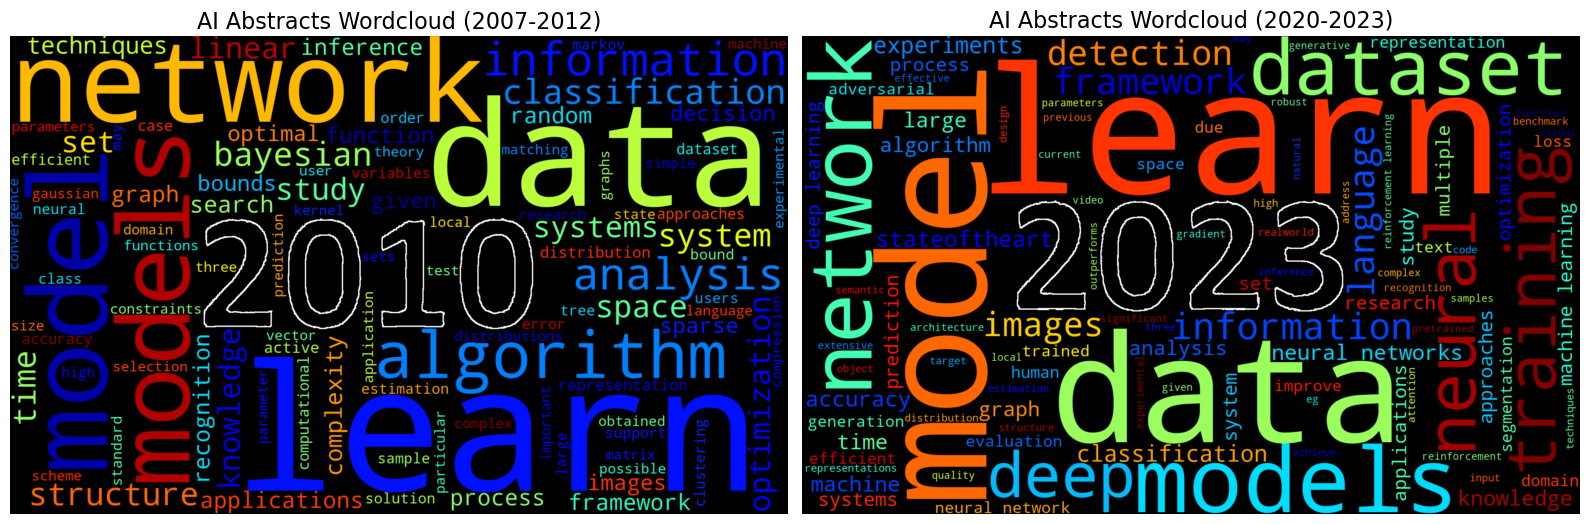

In [13]:
from PIL import Image 
mask_img_2010 = '2010.png'
mask_img_2023 = '2023.png'

mask_2010 = mask = np.array(Image.open(mask_img_2010))
inverted_mask_2010 = np.invert(mask_2010)
mask_2023 = mask = np.array(Image.open(mask_img_2023))
inverted_mask_2023 = np.invert(mask_2023)

def create_wordcloud(freq, mask):
    wordcloud = WordCloud(colormap="jet",width=800,mask=mask,height=400, background_color='black',contour_width=4, 
                    contour_color='white', max_words=100, max_font_size=400).generate_from_frequencies(freq)
    return wordcloud

wordcloud_2007_2010 = create_wordcloud(freq_2007_2010, inverted_mask_2010)
wordcloud_2020_2023 = create_wordcloud(freq_2020_2023, inverted_mask_2023)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8)) # Plot the wordclouds side by side
ax1.imshow(wordcloud_2007_2010, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("AI Abstracts Wordcloud (2007-2012)", fontsize=16)
ax2.imshow(wordcloud_2020_2023, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("AI Abstracts Wordcloud (2020-2023)", fontsize=16)
plt.tight_layout()
plt.show()

## Analysing Relative Frequency Changes of Words Between Time Periods

Next, I focused on calculating and visualising the relative frequency differences of words between the two time periods: 2007-2010 and 2020-2023.

### Calculation Steps

1. I calculated the relative frequency using the frequency dictionary and the total word count for each time period.
2. I sorted the tokens dictionary (based on values) to identify the ones that experienced the highest growth and the steepest decline in usage.

### Visualisation

To present the findings, I created a side-by-side bar graph that showcases the top growing and shrinking words. This visualisation allows for a clear comparison of how word usage has changed over time in the AI category papers. I opted for back to back graphs with striking colours and not many visable axis.


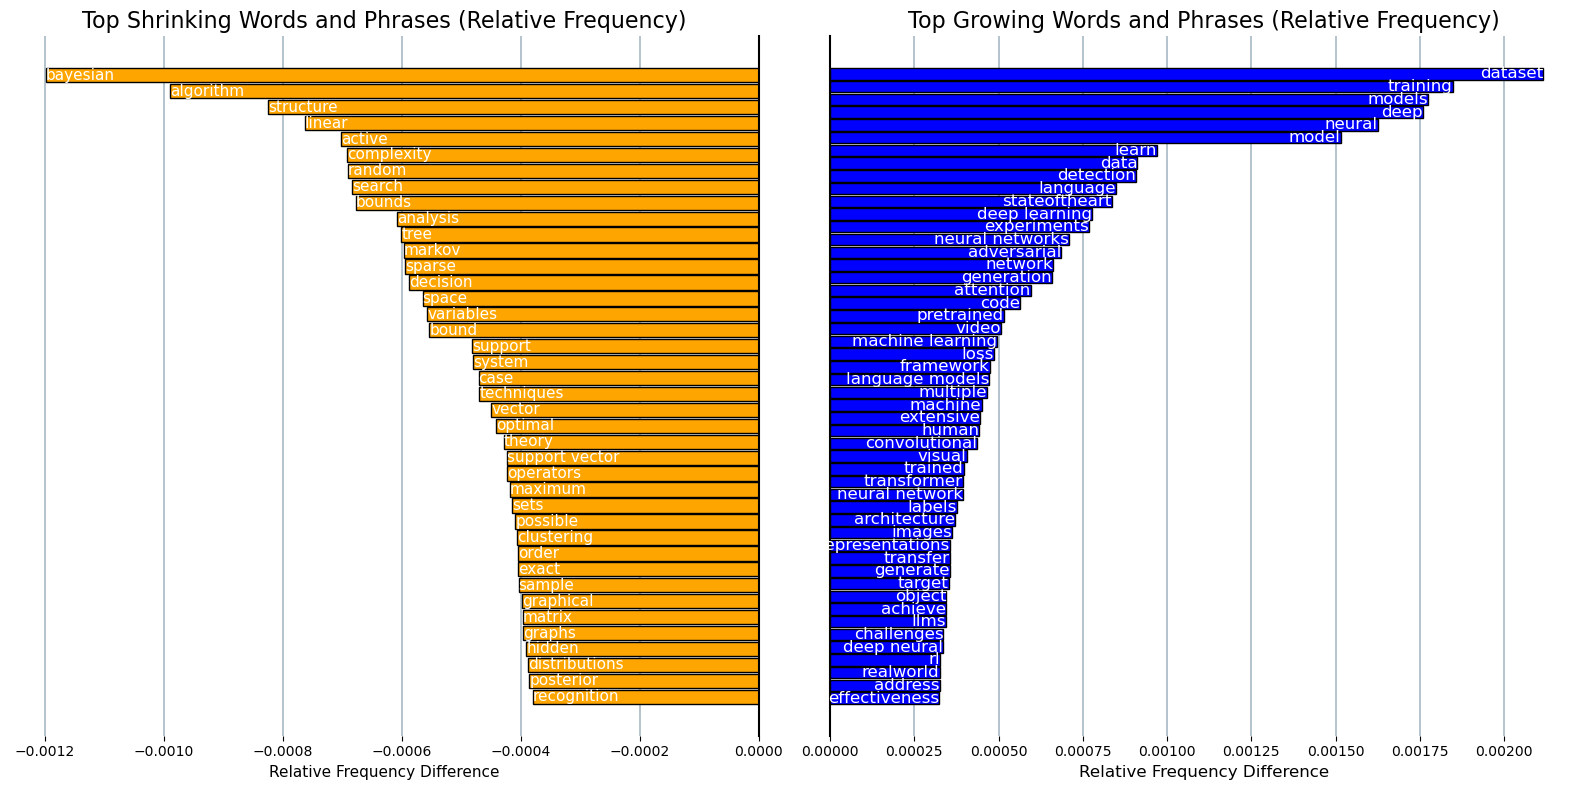

In [14]:
freq_diff = {}
for word in set(freq_2007_2010.keys()) | set(freq_2020_2023.keys()):
    rel_freq_2007_2010 = freq_2007_2010.get(word, 0) / total_words_2007_2010
    rel_freq_2020_2023 = freq_2020_2023.get(word, 0) / total_words_2020_2023
    freq_diff[word] = rel_freq_2020_2023 - rel_freq_2007_2010
#sorting the freq_diff based on its values of relative frequency difference
sorted_words = sorted(freq_diff.items(), key=lambda x: x[1], reverse=True) 

top_growing = sorted_words[:50] # Get the top growing and shrinking words
top_shrinking = sorted_words[-1:-41:-1]
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 8))
plt.subplots_adjust(wspace=0)
# Subplot 1: Top Growing Words and Phrases
ax1.barh([word for word, _ in top_growing], [freq for _, freq in top_growing], color='blue',edgecolor='black', height=0.9)
ax1.set_title("Top Growing Words and Phrases (Relative Frequency)", fontsize=16)
ax1.set_xlabel("Relative Frequency Difference", fontsize=12)
ax1.tick_params(axis='y', which='both', length=0)  # Remove y-axis ticks
ax1.set_yticks([])  # Remove y-axis labels
ax1.invert_yaxis()

ax1.set_axisbelow(True)
ax1.grid(axis = "x", color="#A8BAC4", lw=1.2)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["left"].set_lw(1.5)
for i, (word, freq) in enumerate(top_growing):
    ax1.text(freq, i, word, ha='right', va='center', fontsize=12, color='white')
plt.subplots_adjust(wspace=0)
# Subplot 2: Top Shrinking Words and Phrases
ax2.barh([word for word, _ in top_shrinking], [freq for _, freq in top_shrinking], color='orange',edgecolor='black', height=0.9)
ax2.set_title("Top Shrinking Words and Phrases (Relative Frequency)", fontsize=16)
ax2.set_xlabel("Relative Frequency Difference", fontsize=11)
ax2.tick_params(axis='y', which='both', length=0)  # Remove y-axis ticks
ax2.set_yticks([])  # Remove y-axis labels
ax2.invert_yaxis()

ax2.set_axisbelow(True)
ax2.grid(axis = "x", color="#A8BAC4", lw=1.2)
ax2.spines["left"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.spines["right"].set_lw(1.5)
for i, (word, freq) in enumerate(top_shrinking):
    ax2.text(freq, i, word, ha='left', va='center', fontsize=11, color='white')
    
plt.subplots_adjust(wspace=0)
plt.tight_layout()
plt.show()

## Visualising the AI Category Breakdown

I chose to plot a doughnut chart to illustrate the breakdown between the AI categories in my selected subset of the dataset. To prepare the data for plotting, I simply counted the occurrences of each primary category.

It's important to note that I focused on the first category listed for each paper, which I considered to be the primary category. I found this approach to be the most effective way to represent the data, as some papers listed multiple minor categories while others only mentioned their main research focus.

To enhance the visualisation, I exploded the largest category and included a legend, as the category labels were quite lengthy.


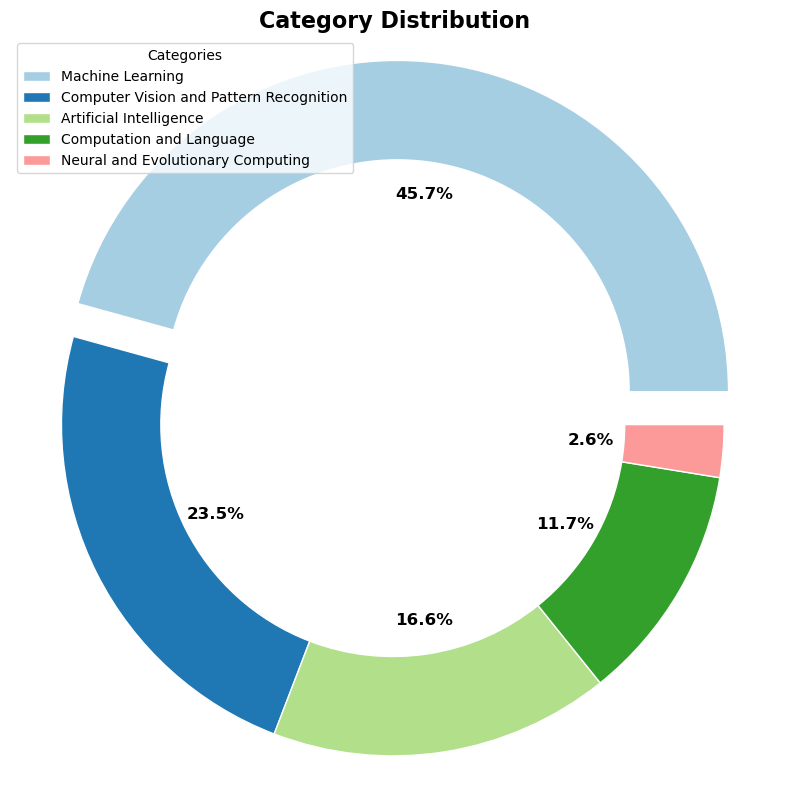

In [15]:
category_counts = ai_mask_df['categories'].value_counts()

plt.figure(figsize=(8, 8))
colors = plt.cm.Paired(range(len(category_counts))) 
explode = [0.1 if i == 0 else 0 for i in range(len(category_counts))]  # Explode the first wedge

plt.pie(category_counts, colors=colors, explode=explode,
        autopct='%1.1f%%', wedgeprops={'width': 0.3, 'edgecolor': 'white'},textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'}
                )
plt.legend(category_counts.index, loc='upper left', title='Categories')
plt.title('Category Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

## Visualising AI Paper Growth and Category Trends

For the next graph, I focus on showcasing the growth in the number of AI papers while also providing insights into the growth of different categories over time.

What important change I made is that I modified the dataframe order so the legend emulates the same order and colours used in the pie chart. I used the fact the legend order is determined by the order in which the categories first appear in the dataframe.
### Smoothing the Graph with Moving Averages

To smooth out the graph and account for high-frequency release months and less popular release months (like December), I employ moving averages:

1. I use the pandas `rolling()` method to create a rolling window.
2. I calculate the mean of the rolling window using the `mean()` function.
3. I apply this function to the DataFrame using the `transform()` method.

By applying moving averages, I create a clearer representation of the overall growth trends in AI papers and different categories, mitigating the impact of short-term fluctuations and seasonality.


<Figure size 1200x800 with 0 Axes>

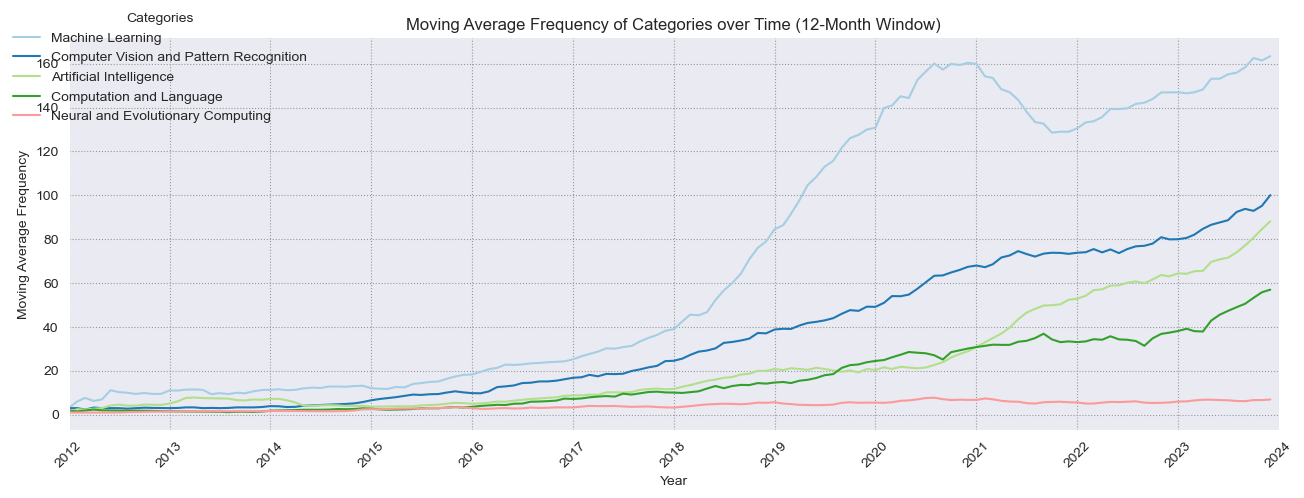

In [16]:
def calculate_moving_average(group, window_size):
    return group.rolling(window=window_size, min_periods=1).mean()

ai_mask_df_filtered = ai_mask_df[(ai_mask_df['update_date'] >= '2012-01-01') & (ai_mask_df['update_date'] <= '2023-12-31')]

ai_mask_df_filtered['year_month'] = ai_mask_df_filtered['update_date'].copy()
ai_mask_df_filtered['year_month'] = ai_mask_df_filtered['year_month'].dt.to_period('M')
frequency_df = ai_mask_df_filtered.groupby(['year_month', 'categories']).size().reset_index(name='frequency')
frequency_df['year_month'] = frequency_df['year_month'].dt.to_timestamp()

# Calculate the moving average
window_size = 12  # Adjust the window size as needed (e.g., 12 for 12-month moving average)
frequency_df['moving_average'] = frequency_df.groupby('categories')['frequency'].transform(
    calculate_moving_average, window_size=window_size
)

#used same category order as piechart to copy the legend format
new_order = [3,2, 0, 1, 4]
frequency_df.iloc[:5] = frequency_df.iloc[new_order].values

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_palette("Paired")

plt.figure(figsize=(12, 8))
ax = sns.relplot(
    data=frequency_df,
    x="year_month", y="moving_average",
    hue="categories",
    kind="line",
    height=5, aspect=2
)
plt.xlabel('Year')
plt.ylabel('Moving Average Frequency')
plt.title(f'Moving Average Frequency of Categories over Time ({window_size}-Month Window)')
plt.grid(True)

sns.move_legend(ax, loc='upper left',title='Categories')

plt.xlim(left=pd.Timestamp('2012-01-01'), right=pd.Timestamp('2023-12-31'))
tick_positions = pd.date_range(start=f'2012-01-01', end=f'2024-01-01', freq='YS')
tick_labels = range(2012, 2025)
plt.xticks(tick_positions, tick_labels, rotation=45)

plt.tight_layout()
plt.show();

## Analysing AI Phrase Trends Over Time

In the next section, I perform calculations on the datasets `title` and `abstract` columns to determine AI phrase trends over time across all AI papers.

### Preparation

1. Using my word cloud and knowledge of AI terminology, I define the phrases to look for in my list called 'terms'.
2. I create a DataFrame called `freq_df` to store the frequency of every term for each year.

### Calculation

1. I iterate over the year range and count the number of papers published in each year.
2. For each year, I count the instances of each term used in the papers.
3. I calculate the frequency of term usage per paper released and store the results in `freq_df`.

### Data Restructuring

1. I restructure the DataFrame and split it into two groups to better suit the requirements of Seaborn for plotting.
2. I use the 'group' column in the melted DataFrame `melted_df` for plotting, ensuring each term is assigned to the correct group.

By performing these calculations and restructuring the data, I prepare it for visualisation using Seaborn to effectively showcase the AI phrase trends over time.

In [17]:
ai_mask_df['update_date'] = pd.to_datetime(ai_mask_df['update_date'])
ai_mask_df['text'] = ai_mask_df['title'].astype(str) + ' ' + ai_mask_df['abstract'].astype(str)
df_filtered = ai_mask_df[(ai_mask_df['update_date'] >= '2007-01-01') & (ai_mask_df['update_date'] <= '2023-12-31')]

# Define the terms to search for
terms = ['neural network', 'reinforcement learning', 'dataset', 'deep learning', 'trained', 'generative',
     'explainability', 'interpretability', 'image', 'video', 'large language model', 'transformer',
     'self supervised learning']

freq_df = pd.DataFrame(columns=['year'] + terms)
ai_mask_df['terms_used'] = ""

for year in range(2007, 2024):
    df_year = df_filtered[(df_filtered['update_date'] >= f'{year}-01-01') & (df_filtered['update_date'] <= f'{year}-12-31')]

    num_papers = len(df_year) # counting the number of papers in the current year
    freq_per_paper = {'year': year}

    for term in terms:
        term_count = df_year['text'].str.count(term).sum()
        freq_per_paper[term] = term_count / num_papers # Calculate the frequency per paper for the current term and year
    
    freq_per_paper_df = pd.DataFrame(freq_per_paper, index=[0])
    freq_df = pd.concat([freq_df, freq_per_paper_df], ignore_index=True)
    
# melt the DataFrame to convert terms to a single column
melted_df = pd.melt(freq_df, id_vars='year', var_name='term', value_name='frequency')

# define the two groups of terms
group1 = ['image', 'video', 'large language model', 'deep learning', 'neural network', 'dataset', 'trained']
group2 = ['self supervised learning', 'transformer', 'reinforcement learning', 'generative', 'explainability', 'interpretability']

melted_df['group'] = melted_df['term'].apply(lambda x: 'Group 1' if x in group1 else ('Group 2' if x in group2 else 'Other'))

## Visualising AI Phrase Trends Over the Last Decade

I graphed the phrase counts over time to illustrate how AI's academic focus and trends have evolved over the last decade.

### Graph 1: Broader Terms

The left graph focuses on broader terms used outside of academia, providing insights into the general perception and discussion of AI topics.

### Graph 2: Technical Shifts

The right graph concentrates on technical shifts over time, highlighting the changes in AI methodologies and approaches within the academic community.

By presenting these two graphs side by side, I offer a comprehensive view of how AI has progressed both in terms of general understanding and technical advancements. This visualisation enables readers to grasp the significant trends and shifts in AI research over the past decade.

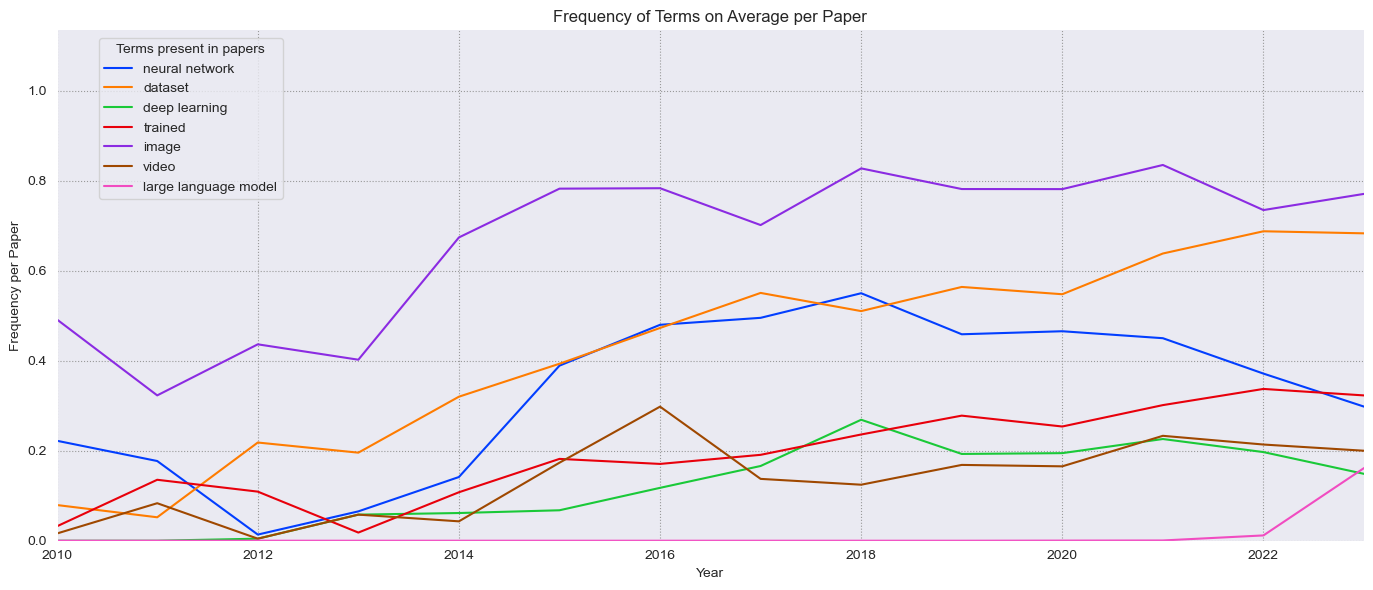

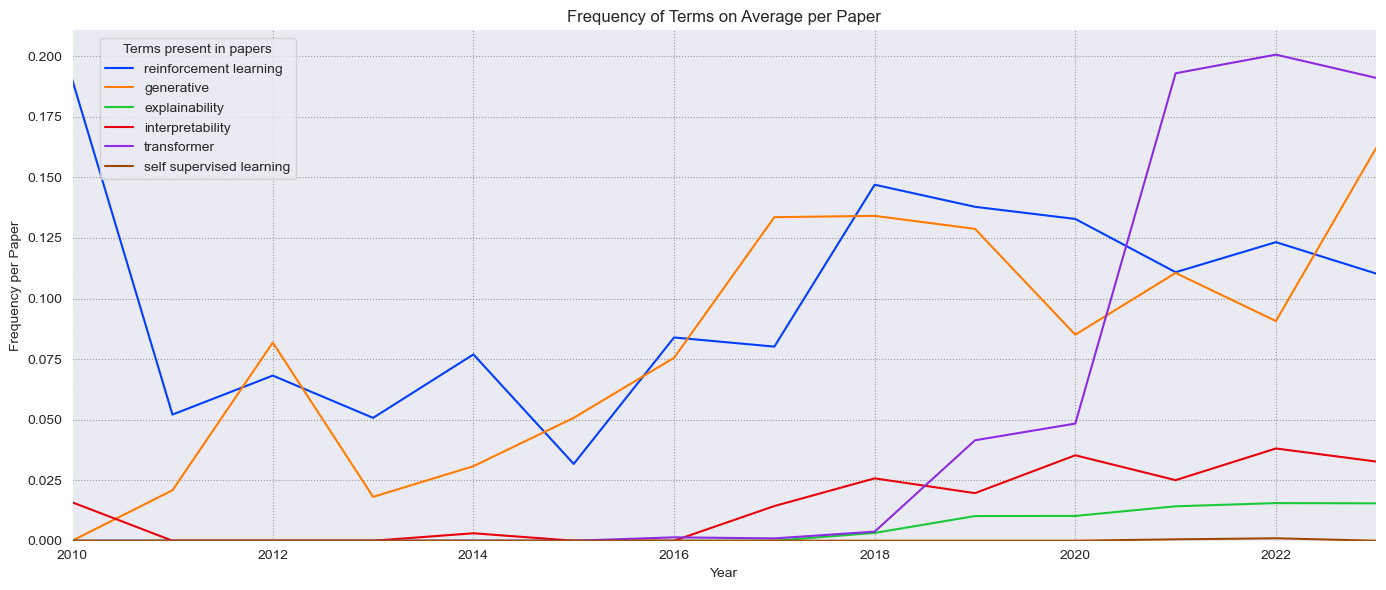

In [18]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_palette("bright")
# Group 1 plot
g1 = sns.relplot(
data=melted_df[melted_df['group'] == 'Group 1'],
x="year", y="frequency", hue="term",
height=6, aspect=2,
kind="line",
).set(
    title="Frequency of Terms on Average per Paper",
    ylabel="Frequency per Paper",
    xlabel="Year",ylim=(0, None),xlim=(2010, 2023)
)
sns.move_legend(g1, "upper left", bbox_to_anchor=(.07, .94), title='Terms present in papers',frameon=True)
plt.tight_layout()

# Group 2 plot
g2 = sns.relplot(
    data=melted_df[melted_df['group'] == 'Group 2'],
    x="year", y="frequency", hue="term",
    height=6, aspect=2,
    kind="line",
    
).set(
    title="Frequency of Terms on Average per Paper",
    ylabel="Frequency per Paper",
    xlabel="Year",ylim=(0, None) ,xlim=(2010, 2023)
)
sns.move_legend(g2, "upper left", bbox_to_anchor=(.07, .94), title='Terms present in papers',frameon=True)

plt.tight_layout()
plt.show()

## Identifying the Most Impactful AI Papers

My goal was to identify the most impactful AI papers based on their release time and citation count. However, the main challenge was that older papers tend to have higher citation counts due to their longer availability.

### Accounting for Paper Age

To account for the age of the papers, I used the z-score, which measures how many citations a paper received compared to its peers in the month of its release.

### Calculating the Z-Score

1. I calculated the z-score value using NumPy's maths functions and groupbys.
2. I ensured that any calculations resulting from dividing by zero were properly handled.

By using the z-score, I normalised the citation counts based on the paper's age, allowing for a fairer comparison of impact across different time periods. This approach helps identify the most influential AI papers while considering the temporal context of their publication.


In [19]:
# Calculate the weekly mean and standard deviation of citation counts
weekly_mean = ai_mask_df.groupby(pd.Grouper(key='update_date', freq='W'))['citation count'].transform('mean')
weekly_std = ai_mask_df.groupby(pd.Grouper(key='update_date', freq='W'))['citation count'].transform('std')

ai_mask_df['mean'] = weekly_mean # Add the weekly statistics as new columns to the original DataFrame
ai_mask_df['std'] = weekly_std
# Calculate the z-score for each paper
ai_mask_df['z_score'] = (ai_mask_df['citation count'] - ai_mask_df['mean']) / ai_mask_df['std']
# Replace inf values with NaN
ai_mask_df['z_score'] = ai_mask_df['z_score'].replace([np.inf, -np.inf], np.nan)

ai_mask_df = ai_mask_df.drop(['mean', 'std'], axis=1)
ai_mask_df = ai_mask_df.drop_duplicates(subset=['id'])

## Visualising the Most Impactful AI Papers and Growth Trend

Using z-scores and further processing, I aim to create a bubble plot that showcases the most impactful AI papers in the last decade, along with the overall AI papers released growth trend.

### Data Filtering

1. I filter the papers to select a time period that best fits my research question.
2. I choose the top 100 most impactful papers based on their z-scores.

### Calculating Papers Released Near Impactful Papers

To display the overall AI paper release trend on the y-axis, I calculate the number of papers released within 30 days of each impactful paper:

1. For each impactful paper, I determine the start and end dates based on its release date.
2. I count the number of papers (cells) that fall within the defined date range.

By visualising the most impactful papers as bubbles and incorporating the paper release trend, I create a comprehensive representation of the AI research landscape over the last decade. This plot highlights the significant contributions while also depicting the growth and evolution of AI research.

In [20]:
ai_mask_df_filtered = ai_mask_df[(ai_mask_df['update_date'] >= '2007-01-01') & (ai_mask_df['update_date'] <= '2023-12-31')]
top_100_papers = ai_mask_df_filtered.nlargest(100, 'z_score')

# function to calculate the number of papers released within one month of each paper's release date
def count_papers_per_month(row, ai_mask_df_filtered):
    start_date = row['update_date'] - pd.Timedelta(days=30)
    end_date = row['update_date'] + pd.Timedelta(days=30)
    mask = (ai_mask_df_filtered['update_date'] >= start_date) & (ai_mask_df_filtered['update_date'] <= end_date)
    return len(ai_mask_df_filtered[mask])

top_100_papers['papers_per_month'] = top_100_papers.apply(count_papers_per_month, args=(ai_mask_df_filtered,), axis=1)

## Plotting the Bubble Graph with Seaborn Scatterplot

Moving on to plotting the graph using Seaborn `scatterplot`, I manually apply the legend to the top 10 most impactful papers:

1. I assign a unique colour to each of the top 10 papers.
2. I replot these papers with their assigned colours.
3. I include the original pre-word-processed title ('`old_title`') to attach to the points in my legend.

### Creating a Linear Regression Model

To create a linear regression model, I use scikit-learn (`sklearn`):

1. I fit the `linear regression model` to my data.
2. I predict the values for the linear regression line.

### Graph Enhancements

To improve the graph's readability and presentation:

1. I clean up the graph by removing unnecessary elements.
2. I add informative labels to provide context.
3. I set the x-axis to display only year values, making the timeline more intuitive.

By applying these enhancements and incorporating the linear regression line, I create a visually appealing and informative graph that effectively communicates the most impactful AI papers and the overall growth trend in the field.


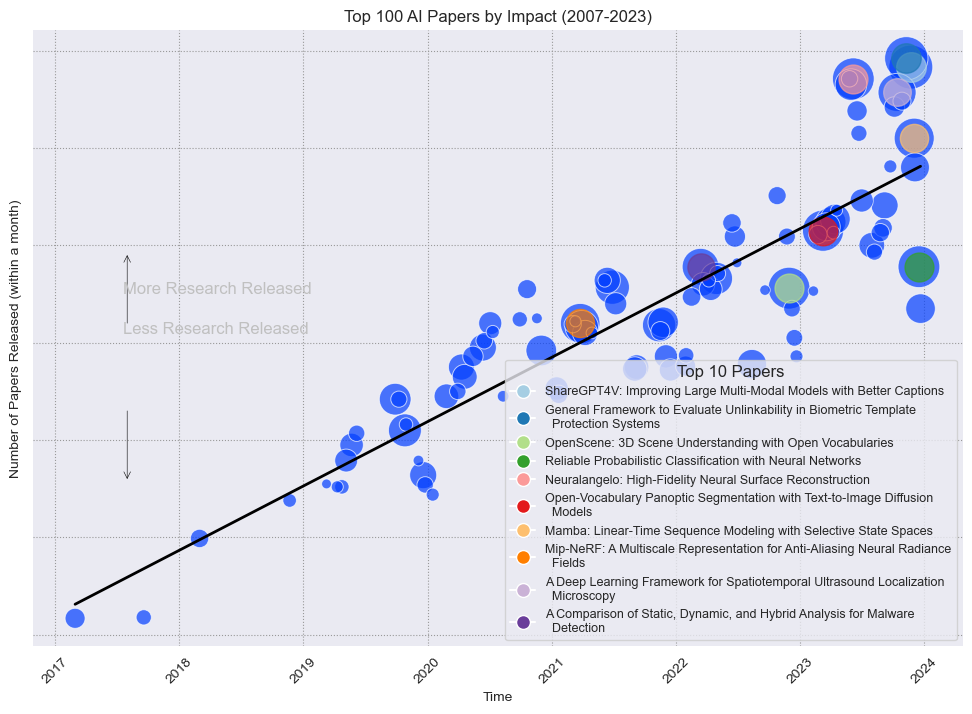

In [21]:
from sklearn.linear_model import LinearRegression

fig, bubble = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=top_100_papers, x='update_date', y='papers_per_month', size='z_score', sizes=(50, 1000), alpha=0.7, legend=False, ax=bubble)
sns.set_theme(style="darkgrid")
sns.set_palette("Blues_r")

top_10_papers = top_100_papers.nlargest(10, 'z_score') # Create a legend for the top 10 papers
colors = sns.color_palette("Paired", len(top_10_papers))
legend_elements = []
for i, (_, row) in enumerate(top_10_papers.iterrows()):
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=row['old_title'],
                                  markerfacecolor=colors[i], markersize=10))
    # Plot the top 10 points with the corresponding color
    bubble.scatter(row['update_date'], row['papers_per_month'], s=row['z_score']*50, color=colors[i], alpha=0.7)

bubble.legend(handles=legend_elements, loc='lower right', fontsize=9, title='Top 10 Papers')

# Fit a linear regression line using sklearn
X = top_100_papers['update_date'].astype('int64').values.reshape(-1, 1)
y = top_100_papers['papers_per_month'].values.reshape(-1, 1)

linear_reg = LinearRegression()
linear_reg.fit(X, y)

X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_plot = linear_reg.predict(X_plot)

bubble.plot(pd.to_datetime(X_plot.ravel()), y_plot, color='black', linewidth=2)

bubble.set_xlabel('Time')
bubble.set_ylabel('Number of Papers Released (within a month)')
bubble.set_title('Top 100 AI Papers by Impact (2007-2023)')

bubble.spines['left'].set_visible(False)
bubble.spines['top'].set_visible(False)
bubble.spines['right'].set_visible(False)
bubble.spines['bottom'].set_visible(False)
bubble.set_yticklabels([])
bubble.tick_params(axis='y', which='both', length=0)
# Set the x-axis locator and formatter to display years only
tick_positions = pd.date_range(start=f'2017-01-01', end=f'2024-01-01', freq='YS')

plt.xticks(rotation=45)

more_research_text = fig.text(0.2, 0.55, 'More Research Released', color='silver', size=12)
less_research_text = fig.text(0.2, 0.5, 'Less Research Released', color='silver', size=12)

arrow_x = pd.to_datetime('2017-08-01')

arrow_style = dict(facecolor='black', edgecolor='black', arrowstyle='->', shrinkA=0, shrinkB=0, lw=0.4)
plt.annotate('', xy=(arrow_x, 490), xytext=(arrow_x, 420),
             arrowprops=arrow_style)
arrow_style_red = dict(facecolor='black', edgecolor='black', arrowstyle='->', shrinkA=0, shrinkB=0, lw=0.4)
plt.annotate('', xy=(arrow_x, 260), xytext=(arrow_x, 330),
             arrowprops=arrow_style_red)
plt.show()

## Preparing Data for a World Heatmap

I plan to use the country values attached to the papers to create a heatmap of the world. To manipulate my data for this purpose, I follow these steps:

1. I ensure that every country present in each cell is counted, considering that a single paper may have multiple countries associated with it.
2. I group the country counts by the year the paper was released.
3. I restructure my DataFrame to be compatible with the Plotly Express function I will use in the next cell.

By aggregating the country data and transforming the DataFrame, I prepare the data for visualisation as a world heatmap. This heatmap will provide insights into the geographical distribution of AI research over time.


In [22]:
ai_mask_df['year'] = pd.to_datetime(ai_mask_df['update_date'], format='%Y').dt.year.astype(str)
ai_mask_df = ai_mask_df[(ai_mask_df['year'] >= '2007') & (ai_mask_df['year'] <= '2023')]
ai_mask_df = ai_mask_df.sort_values('year')
print(ai_mask_df.columns)
ai_mask_df['Country'] = ai_mask_df['Country'].str.split(',')
ai_mask_df_exploded = ai_mask_df.explode('Country')
ai_mask_df_exploded['Country'] = ai_mask_df_exploded['Country'].str.strip()

grouped_df = ai_mask_df_exploded.groupby(['year', 'Country']).size().reset_index(name='count')

df = grouped_df.pivot(index='year', columns='Country', values='count')

df = df.fillna(0)
df = df.reset_index()
df['year'] = df['year'].astype(str)


countries = df.columns[1:]  # Get the list of countries excluding 'year' column

# Create a DataFrame for the choropleth map
dfmap = pd.melt(df, id_vars=['year'], value_vars=countries, var_name='Country', value_name='count')

Index(['id', 'submitter', 'authors', 'title', 'categories', 'abstract',
       'update_date', 'authors_parsed', 'first_version_created', 'old_title',
       'citation count', 'author names', 'author affiliations', 'Country',
       'text', 'terms_used', 'z_score', 'year'],
      dtype='object')


## Creating an Animated World Heatmap with Plotly Express

I utilise the Plotly Express choropleth function to create an animated map showcasing AI-related paper releases across different years.

### Log Scale

To prevent the countries with the highest number of paper releases from dominating the scale, I apply a log scale to the data. This ensures a more balanced representation of the global AI research landscape.

By leveraging the Plotly Express choropleth function and applying a log scale, I create an engaging and informative animated world heatmap that highlights the geographical distribution and growth of AI research over time.


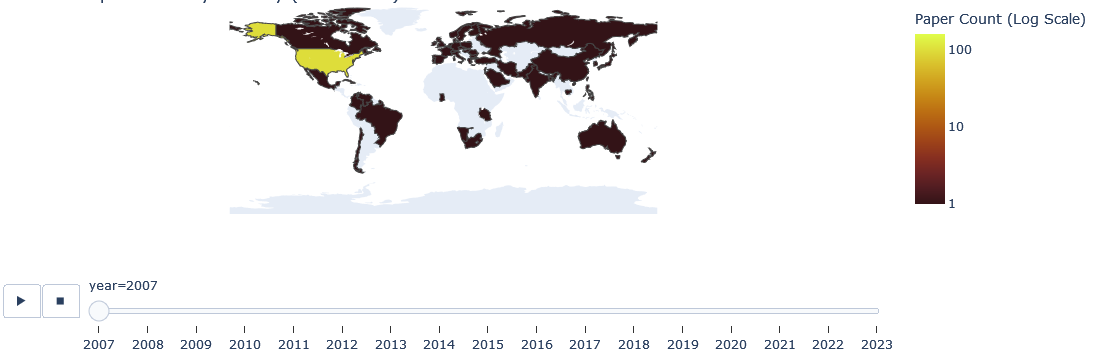

In [23]:
fig = px.choropleth(dfmap, 
                    locations='Country',
                    locationmode='country names',
                    color='count',
                    color_continuous_scale='solar',
                    animation_frame='year',
                    range_color=(0, np.log10(dfmap['count'].max())),
                    title='AI Paper Count by Country (2008-2023)')

fig.update_layout(
    geo=dict(
        showframe=False,showcoastlines=False,projection_type='equirectangular'),
    coloraxis_colorbar=dict(
        title='Paper Count (Log Scale)',
        tickvals=[0, 1, 2, 3],
        ticktext=['1', '10', '100', '1000']
    ),
    coloraxis=dict(
        colorscale='solar',
        colorbar=dict(
            tickmode='array',
            tickvals=[0, 1, 2, 3],
            ticktext=['1', '10', '100', '1000']
        )
    )
)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show(block=False)

## Visualising Impactful Papers with a Treemap

I aimed to create a visualisation that showcases the most impactful papers, their impact, and additional information. After attempting a network graph but finding insufficient connections between papers, I opted for a treemap using Plotly Express.

#### Data Preparation Challenge: Word Wrapping

The main data preparation challenge was properly wrapping words in the visualisation, as Plotly had no built-in word wrapping functionality, and I had long titles for all my papers.

Solution:
1. I used the `textwrap` library in a function to pre-wrap my text, a method suggested on the Plotly forums.
2. As Plotly's labelling functions for this graph type didn't meet my needs, I simply pre-combined the label in a pandas column before using Plotly.

By employing a treemap and addressing the word wrapping challenge, I create an informative and visually appealing representation of the most impactful papers, their significance, and relevant details.


In [24]:
import textwrap
top_100_papers = ai_mask_df.nlargest(35, 'z_score')
print(top_100_papers.columns)
#method suggested on https://community.plotly.com/t/wrap-long-text-in-title-in-dash/11419/8
def customwrap(s,width=18):
    return "<br>".join(textwrap.wrap(s,width=width))

top_100_papers['old_title_newlines'] = top_100_papers['old_title'].map(customwrap)


Index(['id', 'submitter', 'authors', 'title', 'categories', 'abstract',
       'update_date', 'authors_parsed', 'first_version_created', 'old_title',
       'citation count', 'author names', 'author affiliations', 'Country',
       'text', 'terms_used', 'z_score', 'year'],
      dtype='object')


## Plotly Treemap: Visualising Impact and Citation Count

I create a Plotly treemap where:
- The size of the squares represents the impact score (z-score) of each paper.
- The colour scale represents the pure citation count.

### Additional Information

To provide further insights about each paper, I utilise the treemap buckets to display:
- Categories
- Year of release

By leveraging the Plotly treemap and incorporating additional information through the buckets, I create a comprehensive visualisation that allows viewers to grasp the impact and citation count of each paper while also providing context about their categories and publication year.


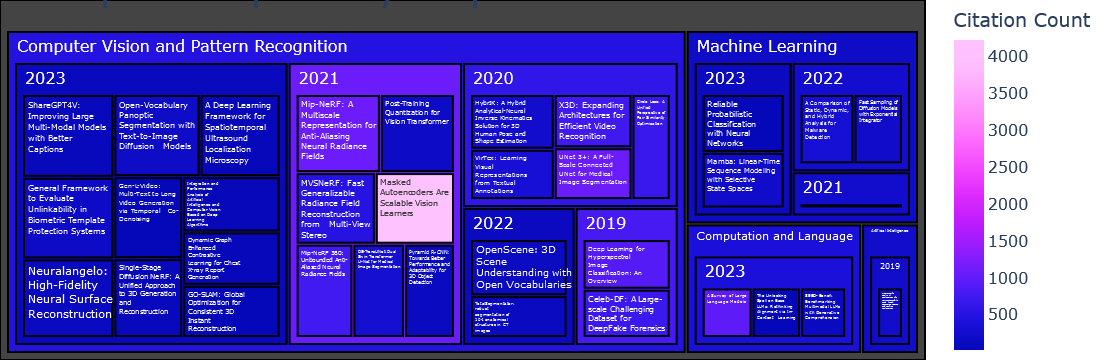

In [25]:
import plotly.graph_objects as go
fig = px.treemap(
    top_100_papers,
    path=['categories','year', 'old_title_newlines'],
    values='z_score',
    names='citation count',
    color='citation count',
    color_continuous_scale='plotly3',
    title='Top 50 Papers by Impactfulness',
    hover_data={
        'z_score': ':.2f',
        'citation count': True,
        'update_date': True
    },
    labels={
        'z_score': 'Z score',
        'old_title_newlines': 'Title',
    })

fig.update_layout(coloraxis_colorbar=dict(title="Citation Count"))

fig.update_layout(
    font_size=16,
    margin=dict(t=0, l=0, r=0, b=0),
    title_font_size=40
    
)
fig.update_traces(marker=dict(line=dict(color='black', width=2)),pathbar=dict(thickness=12))
fig.show()

## Combining Graphs to Show the Growth of Transformers and Large Language Models

I combined my graphs to showcase the significant growth trends in transformers and large language models within the AI field, which correlate with the overall academic growth in AI.

I decided to examine these trends in detail while also incorporating my findings on impactful papers. Furthermore, I combined what I learned about impactful papers and AI growth trends with data from my Google Trends dataset, which I discuss in more detail in the next section of my notebook.

By bringing together these various elements, I aim to provide a comprehensive overview of the key developments and influences in the AI landscape.


### Counting Phrase Growth

Using the same methods as before, I counted the monthly growth of the phrases **'large language model' (llm)** and 'transformer' in my dataset. This allowed me to track the increasing popularity of these specific terms over time.

By analysing the frequency of these phrases on a monthly basis, I gained insights into the trends and adoption of large language models and transformer architectures within the AI research community.


In [26]:
terms = ['large language model', 'transformer']
freq_df = pd.DataFrame(columns=['date'] + terms)

for year in range(2007, 2024):
    for month in range(1, 13):
        date = f'{year}-{month:02d}-01'
        
        start_date = pd.to_datetime(date)
        end_date = pd.to_datetime(f'{year}-{month:02d}-{pd.Timestamp(year, month, 1).days_in_month}')
        df_month = df_filtered[(df_filtered['update_date'] >= start_date) & (df_filtered['update_date'] <= end_date)]
        num_papers = len(df_month)
        
        freq_per_paper = {'date': date}
        for term in terms:

            term_count = df_month['abstract'].str.count(term).sum() + df_month['title'].str.count(term).sum()
            freq_per_paper[term] = term_count / num_papers if num_papers > 0 else 0

        freq_per_paper_df = pd.DataFrame(freq_per_paper, index=[0])
        freq_df = pd.concat([freq_df, freq_per_paper_df], ignore_index=True)

### Combining Data Sources for Bubble Graph

I used three sources of data for my graph:

1. The most impactful papers I identified based on z-score that involved or used transformers or LLMs in their abstracts or titles.
2. The `freq_df`, which contains the frequency of 'large language model' and 'transformer' over time in academic papers.
3. The Google Trends data on ChatGPT searches, a product based on a large language model that heavily relies on transformers.

To combine my ChatGPT search data with the paper frequency data, I followed these steps:

1. I normalised both pieces of data so they could appear on the same scale.
2. I changed the formatting of the Google Trends data to match my frequency data.

I used the same methods as before to create the bubble graph, allowing for a clear visualisation of the relationship between the most impactful papers, the frequency of key terms in academic papers, and the popularity of ChatGPT searches over time.


In [27]:
import matplotlib.dates as mdates 
melted_df = pd.melt(freq_df, id_vars=['date'], var_name='term', value_name='frequency')

df_google = pd.read_csv('data/interest_over_time.csv')
columns = ['date', 'chatgpt']
df_google = df_google[columns]
# Create a new column 'term' with the value 'chatgpt'
df_google['term'] = 'chatgpt'
df_google = df_google.rename(columns={'chatgpt': 'normalised_frequency'})

line_data = melted_df[melted_df['term'].isin(['large language model', 'transformer'])]
line_data['normalised_frequency'] = (line_data['frequency'] - line_data['frequency'].min()) / (line_data['frequency'].max() - line_data['frequency'].min()) * 100

line_data = pd.concat([df_google, line_data], ignore_index=True)

Legend_Map= {'chatgpt': 'Public Interest: ChatGPT Google Search Frequency', 'transformer': 'Academic Usage: "Transformer" Term Frequency', 'large language model': 'Academic Usage: "Large Language Model" Term Frequency'}
line_data['term'] = line_data['term'].map(Legend_Map)
# Create the line plot on the second y-axis
line_data['date'] = pd.to_datetime(line_data['date'])

top_1000 = ai_mask_df_filtered.nlargest(1000, 'z_score')


top_1000.loc[top_1000['id'] == '1706.03762', 'abstract'] = top_1000.loc[top_1000['id'] == '1706.03762', 'abstract'].str.replace('\n', ' ')
# Filter the data for the bubble plot
bubble_data = top_1000[(top_1000['abstract'].str.contains('transformer|large language model', case=False)) | 
                       (top_1000['title'].str.contains('transformer|large language model', case=False))]


bubble_data['papers_per_month'] = bubble_data.apply(count_papers_per_month, args=(ai_mask_df_filtered,), axis=1)

## The Transformer Model: A Catalyst for AI Growth

By combining elements from three of my graphs, I demonstrate how the introduction of the transformer model, a deep learning model, triggered a series of significant developments in the AI field:

1. The transformer model led to a surge in impactful papers on the topic.
2. It marked a change in direction for AI as a whole, influencing the focus of research and development.
3. The transformer model contributed to the overall growth of AI, both in academic research and practical applications.
4. It paved the way for the creation of new consumer products such as **ChatGPT**, which ultimately sparked a global AI boom.

This analysis highlights the profound impact of the transformer model on the AI landscape, from academic research to real-world applications and consumer adoption.


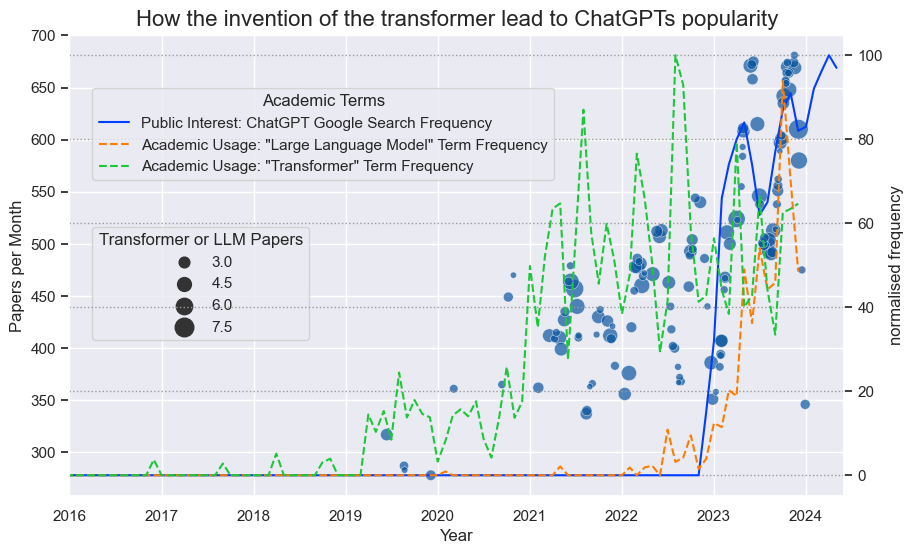

In [28]:
# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

# Create the bubble plot
sns.scatterplot(data=bubble_data, x='update_date', y='papers_per_month', size='z_score', sizes=(20, 200), alpha=0.7, ax=ax1, palette='Blues_r', legend='brief')

# Create a second y-axis
ax2 = ax1.twinx()
sns.lineplot(data=line_data, x='date', y='normalised_frequency', hue='term', ax=ax2,  palette='bright'  )
ax2.lines[1].set_linestyle("--")
ax2.lines[2].set_linestyle("--")

leg = ax2.legend()
leg_lines = leg.get_lines()
leg_lines[1].set_linestyle("--")
leg_lines[2].set_linestyle("--")

ax1.set_xlabel('Year')
ax1.set_title('How the invention of the transformer lead to ChatGPTs popularity', fontsize=16)
ax1.set_ylabel('Papers per Month')
ax2.set_ylabel('normalised frequency')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2024-06-01')
ax1.set_xlim(start_date, end_date)

plt.xticks(rotation=45)
sns.move_legend(ax1 ,"upper left", bbox_to_anchor=(.02, .60), title='Transformer or LLM Papers',frameon=True)
sns.move_legend(ax2 ,"upper left", bbox_to_anchor=(.02, .90), title='Academic Terms',frameon=True)
plt.show()

# **Societal Dataset**

# Gathering the Dataset for Societal Impact of AI from GoogleTrends

I chose **Google Trends** as my data source to explore AI's impact on everyday people and help determine when the modern AI boom began. I used a library called `pytrends`, which utilises Google's unofficial Google Trends API.

I gathered data in two categories:
1. General worldwide interest over time for certain search terms, focusing on how frequently these keywords were searched.
2. Regional search popularity data for the same terms, broken down by region.

The keywords I chose to examine are similar to the academic keywords analysed in the papers. I also selected the names of the **most popular AI service websites worldwide** to gain insights into the growth of consumer-facing AI companies in recent years.

In [29]:
terms = ['neural network','machine learning' ,'natural language processing','reinforcement learning', 'dataset', 'deep learning','trained', 'generative','explainability', 'interpretability', 'large language model', 'transformer', 'self supervised learning', 'gans', 'diffusion model']

ai_services = [ 'chatgpt' ,  'openai',    'deepl',    'character.ai',    'quillbot',    'civitai',    'midjourney',    'remove.bg',    'huggingface', 'perplexity',    'you.com',    'nightcafe',    'poe.com',    'jasper.ai',    'copy.ai',    'elevenlabs',    'cutout',    'playgroundai',    'pimeyes',    'appen',    'leonardo.ai',    'speechify',    'picsart',    'd-id',    'stablediffusion'
]

## Blending in with Normal User Traffic

As `pytrends` uses an unofficial Google Trends API, I took several steps to blend in with normal user traffic:

- I used the Selenium WebDriver to obtain a user cookie for my session request.
- I added numerous sleep intervals between requests.
- I implemented retry and backoff factors for additional sleeping.

I was extremely cautious to avoid having my IP flagged when sending requests.

To initially connect with Google servers, I used the `TrendReq` function from `pytrends`.

In [30]:
def get_cookie():
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    driver = webdriver.Chrome(options=options)
    driver.get("https://trends.google.com/")
    time.sleep(5)
    cookie = driver.get_cookie("NID")["value"]
    driver.quit()
    return cookie
    
def initialise_pytrends():
    nid_cookie = f"NID={get_cookie()}"
    # Connect to Google Trends
    pytrends = TrendReq(hl='en-US', tz=360,retries=10,backoff_factor=0.1, requests_args = {'headers': {'Cookie': nid_cookie}} )

## Main Functions for Requesting Data

I used two main functions for my data requests:

1. `process_terms`: Since Google Trends only supports requesting data for 5 keywords at a time, I used this function to split my larger lists into smaller chunks and keep track of them.

2. `fetch_data`: This was my main request function, inspired by some excellent API requesting functions found online, designed to be more robust. It keeps track of attempts and successfully fetched data to ensure it always returns the correct information, printing an error if not. I use `pytrends.build_payload` to send my API requests.

In [31]:
def process_terms(terms, chunk_size):
    for i in range(0, len(terms), chunk_size):
        term_chunk = terms[i:i + chunk_size]
        yield term_chunk
        
def _fetch_data(pytrends, func, *args, **kwargs):
    """Attempts to fetch data and retries in case of a ResponseError."""
    attempts, fetched = 0, False
    while not fetched:
        try:
            pytrends.build_payload(kwargs['kw_list'], cat=0, timeframe=kwargs['timeframe'], geo='', gprop='')
            print(f"Fetching {func} data...")          
            data = getattr(pytrends, func)()
            fetched = True
        except TooManyRequestsError as err:
            print(err)
            print(f'Trying again in {60 + 5 * attempts} seconds.')
            time.sleep(60 + 5 * attempts)
            attempts += 1
            if attempts > 3:
                print('Failed after 3 attempts, aborting fetching.')
                break
    time.sleep(60)# added end sleep statement so always at least 60s between fetches
    return data if fetched else None

### Retrieving Worldwide Interest Over Time Data

To obtain worldwide interest over time data, I followed these steps:

1. I created a main DataFrame, initialising it with my first chunk of data if no CSV file existed.
2. Whenever I fetched more keyword data, I merged the chunk DataFrames with the main DataFrame.
3. I made sure to drop duplicate columns after each merge.
4. I saved the complete DataFrame every time I retrieved another chunk, using write mode to overwrite outdated saves.


I used the `timeframe='all'` parameter to get the complete timeline Google had on all keywords, allowing me to select my preferred time period when processing the data later.

In [32]:
def get_interest_over_time_data():
    interest_over_time_df = pd.DataFrame()
    for term_chunk in process_terms(terms + ai_services, 5):
        try:
    
            interest_over_time_chunk = _fetch_data(pytrends, 'interest_over_time', kw_list=term_chunk, timeframe='all')
            print(f"pulled chunk {interest_over_time_chunk}")    
            if interest_over_time_chunk is not None:
              
                if os.path.exists('interest_over_time.csv'):
                    # If the CSV file already exists, load it into a DataFrame
                    print(f"current full df from csv before merge{interest_over_time_df}")   
                    interest_over_time_df = interest_over_time_df.merge(interest_over_time_chunk, on='date', how='outer', suffixes=('', '_drop'))
                    interest_over_time_df = interest_over_time_df.loc[:, ~interest_over_time_df.columns.str.endswith('_drop')]
                    print(f"current full df after merge{interest_over_time_df}")   
                else:
                    # If the CSV file doesn't exist, create a new DataFrame with the chunk
                    interest_over_time_df = interest_over_time_chunk.copy()
                interest_over_time_df.to_csv('interest_over_time.csv', mode='w')
        except Exception as e:
            print(f"Error occurred: {str(e)}")
            print("Saving data collected so far...")
            interest_over_time_df.to_csv('interest_over_time.csv', mode='w')
            break

### Gathering Regional Data Over Time

I used very similar methods for gathering regional data over time, with a few key differences:

1. I sent far more requests, sending one complete keyword request for each year from 2007 to 2024.
2. I saved the data in a CSV file corresponding to the year it was from.

 
I used the `country` parameter to return country-specific data, as this better matches the data I have from my academic papers dataset.

In [33]:
def get_regional_data():
    interest_over_time_df = pd.DataFrame()
    start_year = 2007
    end_year = 2024
    # Process terms in chunks of 5 for interest over time
    for term_chunk in process_terms(terms + ai_services, 5):
        try:
            for year in range(start_year, end_year):
                start_date = f"{year}-01-01"
                end_date = f"{year+1}-01-01"
                timeframe = f"{start_date} {end_date}"
                
                interest_over_time_chunk = _fetch_data(pytrends, 'interest_by_region', resolution='COUNTRY', inc_low_vol=True, inc_geo_code=True, kw_list=term_chunk, timeframe=timeframe)
                
                if interest_over_time_chunk is not None:
                    interest_over_time_chunk.index.name = 'Country'
         
                    csv_filename = f'interest_by_region_{year}.csv'
                    if os.path.exists(csv_filename):
      
                        interest_over_time_df = pd.read_csv(csv_filename, index_col='Country')
                        
                        interest_over_time_df = interest_over_time_df.merge(interest_over_time_chunk, on='Country', how='outer')
                    else:
                        interest_over_time_df = interest_over_time_chunk.copy()
                    interest_over_time_df.to_csv(csv_filename, mode='w')
        except Exception as e:
            print(f"Error occurred: {str(e)}")
            break

# Processing and Plotting the Retrieved Data

In this section, I focus on reading the data I have retrieved from CSV files, processing it, and then plotting the graphs.

I divided my data into two groups of keywords:
1. **Academic keywords**: Terms I found to be commonly used in academic papers.
2. **AI website service keywords**: Keywords based on the names of popular AI website services.

This categorisation allows me to analyse and visualise the data more effectively.

In [34]:
df = pd.read_csv('data/interest_over_time.csv')
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_palette("bright")

# Define the keyword groups
terms = ['neural network', 'reinforcement learning', 'dataset', 'deep learning', 'generative',
    ]
terms = ["neural network","machine learning","reinforcement learning","deep learning","generative","explainability"]
ai_services = [ 'chatgpt' ,  'cutout',  'deepl',    'midjourney',   'huggingface', 'perplexity',    'nightcafe',       'elevenlabs',  
]

df_academic = df[['date'] + terms]
df_services = df[['date'] + ai_services]

## Processing Academic Interest Over Time Data

I processed the academic data by converting the Google Trends output into a format suitable for plotting. I followed these steps:

1. I filtered the data for a more appropriate time period for my project.
2. I created a moving average for my interest data using methods similar to those used in my academic dataset, but instead using a lambda function to avoid creating a separate function.
3. I used the pandas `rolling()` method to create a rolling window for the moving average calculation.
4. I changed the dataframe format to be more suitable for plotting

   
This process allowed me to prepare the academic data for visualisation and analysis.

In [35]:
melted_df = df_academic.melt(id_vars='date', var_name='column', value_name='interest')
melted_df['date'] = pd.to_datetime(melted_df['date'])
melted_df = melted_df[(melted_df['date'] >= '2012-01-01') & (melted_df['date'] <= '2024-01-01')]
melted_df['moving_avg'] = melted_df.groupby('column')['interest'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

### Visualising Academic Data

To visualise my academic data, I used a Seaborn `relplot`. I plotted the moving interest average against time, ensuring that only year labels were displayed on the x-axis. This allowed for a clear and easily interpretable representation of the data.

By using Seaborn's `relplot`, I was able to create an informative and visually appealing graph to showcase the trends in academic interest over time.

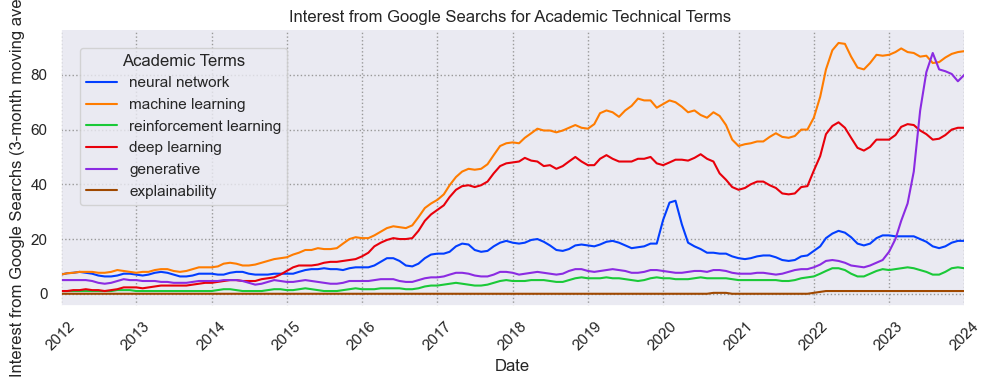

In [36]:
ax1 = sns.relplot(
data=melted_df,
x="date", y="moving_avg", hue="column",
height=4, aspect=2,
kind="line",
)
tick_positions = pd.date_range(start=f'2012-01-01', end=f'2024-01-01', freq='YS')
tick_labels = range(2012, 2025)
plt.xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2024-01-01'))
sns.move_legend(ax1 ,"upper left", bbox_to_anchor=(.08, .88), title='Academic Terms',frameon=True)

plt.title('Interest from Google Searchs for Academic Technical Terms ')
plt.xlabel('Date')
plt.ylabel('Interest from Google Searchs (3-month moving average)')
plt.xticks(tick_positions, tick_labels, rotation=45)
plt.tight_layout()
plt.show()

I followed the same process for my AI service keywords. But I examined a shorter time period.

In [37]:
melted_df = df_services.melt(id_vars='date', var_name='column', value_name='interest')
melted_df['date'] = pd.to_datetime(melted_df['date'])
melted_df = melted_df[(melted_df['date'] >= '2018-01-01') & (melted_df['date'] <= '2024-01-01')]
# Calculate the 3-month moving average for each column
melted_df['moving_avg'] = melted_df.groupby('column')['interest'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

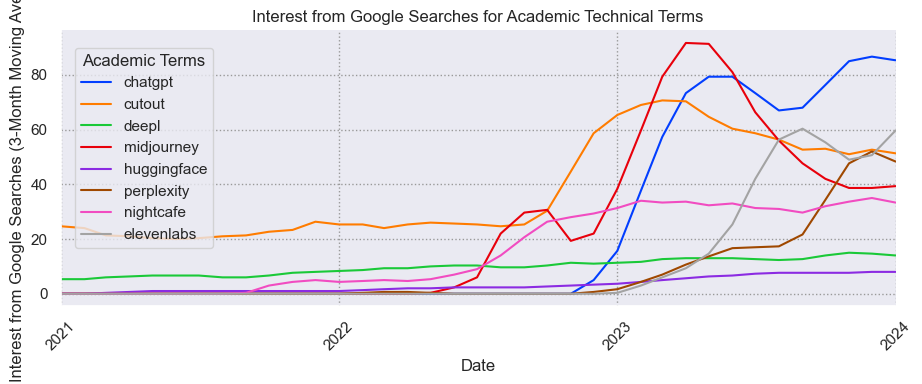

In [38]:
ax1 = sns.relplot(
    data=melted_df,
    x="date", y="moving_avg", hue="column",
    height=4, aspect=2,
    kind="line"
)
tick_positions = pd.date_range(start='2021-01-01', end='2024-01-01', freq='YS')
tick_labels = range(2021, 2025)
plt.xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2024-01-01'))
sns.move_legend(ax1, "upper left", bbox_to_anchor=(.08, .88), title='Academic Terms', frameon=True)
plt.title('Interest from Google Searches for Academic Technical Terms')
plt.xlabel('Date')
plt.ylabel('Interest from Google Searches (3-Month Moving Average)')
plt.xticks(tick_positions, tick_labels, rotation=45)
plt.tight_layout()
plt.show()

### Reading Regional Interest Data

Reading in all my regional interest data was a longer process due to the numerous individual CSV files. Here's how I approached it:

1. I used the CSV file name to identify the year and then read the CSV into a DataFrame.
2. I had to drop some columns due to an error in one of my CSV files.
3. I created an average across keywords in my groups and added a year column to each DataFrame.
4. I saved all the resulting DataFrames into a list for further processing.

This process allowed me to consolidate the regional interest data from multiple files into a single, organised structure for analysis.

In [39]:
# List of CSV file names
csv_files = [f'data/interest_by_region_{year}.csv' for year in range(2007, 2024)]
df_list_terms = []
df_list_services = []

for file in csv_files:
    # Extract the year from the file name
    year = file.split('_')[-1].split('.')[0]
    
    df = pd.read_csv(file, index_col='Country')
    #Fixing Data csv formating error
    droppedcolumns = ['neural network_y','machine learning_y','natural language processing_y','reinforcement learning_y','dataset_y']
    df.drop(droppedcolumns, axis=1, inplace=True)
    df = df.rename(columns={"neural network_x": "neural network", "machine learning_x": 'machine learning',"natural language processing_x":"natural language processing", 'reinforcement learning_x' :'reinforcement learning','dataset_x' :'dataset'})
    
    df['average_interest_terms'] = df[terms].mean(axis=1)
    df['average_interest_services'] = df[ai_services].mean(axis=1)
    df['year'] = year
    # Append the DataFrames to the respective lists
    df_list_terms.append(df[['average_interest_terms', 'year']])
    df_list_services.append(df[['average_interest_services', 'year']])

## Adjusting Regional Interest Data

One challenge I encountered with the Google Trends data was that the regional interest was indexed based on the requested period. This meant that an interest value of 100 from 2004 was significantly lower than an interest value of 100 in 2023, even though the data points were the same. To address this issue, I used my interest over time data and multiplied it with my regional data to obtain accurate regional interest values over time.

I applied this process only to regional data between 2013 and 2024. Here's how I did it:

1. I iterated over my service DataFrame list.
2. Using the year and average value from my interest over time DataFrame, I multiplied all the columns in each regional DataFrame.

This adjustment ensured that the regional interest data accurately reflected the changes in interest levels over time, providing a more meaningful representation of the data.


In [40]:
df_academic['average_terms'] = df_academic[terms].mean(axis=1)
df_services['average_terms'] = df_services[ai_services].mean(axis=1)

df_result = df_services[['date', 'average_terms']].copy()
df_result['date'] = pd.to_datetime(df_result['date'])
df_result.set_index('date', inplace=True)

# Group by year and calculate the mean of 'average_terms'
df_yearly_avg = df_result.resample('Y').mean()

df_yearly_avg.reset_index(inplace=True)
df_yearly_avg['year'] = df_yearly_avg['date'].dt.year
df_yearly_avg.drop('date', axis=1, inplace=True)

df_yearly_avg = df_yearly_avg[df_yearly_avg['year'] >= 2013]
filtered_df_list_services = [df[df['year'].astype(int) >= 2013] for df in df_list_services]

# Create a dictionary to map years to average_terms values
avg_terms_dict = dict(zip(df_yearly_avg['year'], df_yearly_avg['average_terms']))
# Iterate over the list of DataFrames starting from 2013 and multiply the values
for df in filtered_df_list_services[6:]:
    year = int(df['year'].iloc[0])  # Get the year value from the DataFrame
    avg_terms = avg_terms_dict[year]  # Get the corresponding average_terms value
    
    # Multiply all columns except 'year' by the average_terms value
    columns_to_multiply = [col for col in df.columns if col != 'year']
    df[columns_to_multiply] = df[columns_to_multiply] * avg_terms

dfmap_services = pd.concat(filtered_df_list_services)

## Plotting Regional Interest Data

After adjusting the regional interest data, I plotted it using a Plotly Express choropleth graph, employing similar methods to those used in my academic dataset. I chose a logarithmic scale for the color axis to match my other dataset, allowing for easier comparison between the two.

By using a choropleth graph, I was able to effectively visualise the regional interest data on a world map, providing a clear and intuitive representation of the geographic distribution of interest over time.

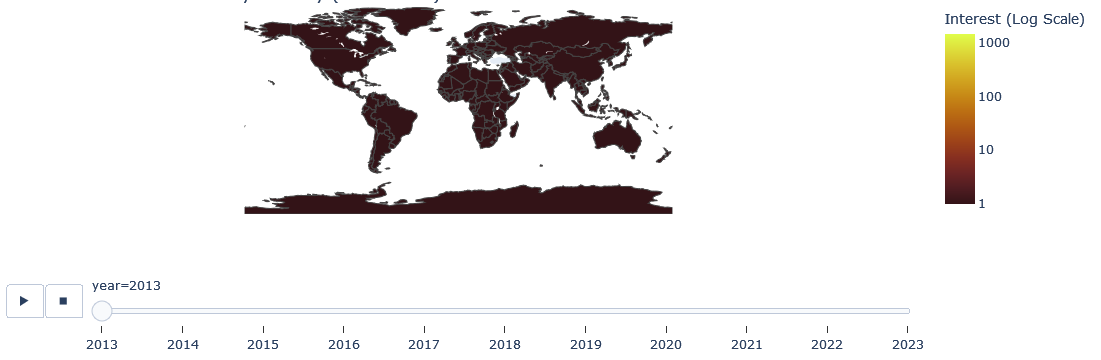

In [41]:
fig_services = px.choropleth(dfmap_services, 
                             locations=dfmap_services.index,
                             locationmode='country names',
                             color='average_interest_services',
                             color_continuous_scale='solar',
                             animation_frame='year',
                             range_color=(0, np.log10(dfmap_services['average_interest_services'].max())),
                             title='AI Services Interest by Country (2007-2023)')

fig_services.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    coloraxis_colorbar=dict(
        title='Interest (Log Scale)',
        tickvals=[0, 1, 2, 3],
        ticktext=['1', '10', '100', '1000']
    ),
    coloraxis=dict(
        colorscale='solar',
        colorbar=dict(
            tickmode='array',
            tickvals=[0, 1, 2, 3],
            ticktext=['1', '10', '100', '1000']
        )
    )
)
fig_services.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig_services.show()